In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from IPython.display import Markdown as md
from IPython.core.display import display, HTML
np.random.seed(42)
sns.set()

In [2]:
switch_df = pd.read_csv("./ARM_Data/arsenic/wells.dat", sep=" ").assign(
    arsenic_log=lambda x: np.log(x.arsenic)
)

In [3]:
switch_df

,switch,arsenic,dist,assoc,educ,arsenic_log
1,1,2.36,16.826000,0,0,0.858662
2,1,0.71,47.321999,0,0,-0.342490
3,0,2.07,20.966999,0,10,0.727549
4,1,1.15,21.486000,0,12,0.139762
5,1,1.10,40.874001,1,14,0.095310
...,...,...,...,...,...,...
3016,0,0.52,19.347000,1,5,-0.653926
3017,0,1.08,21.386000,1,3,0.076961
3018,0,0.51,7.708000,0,4,-0.673345
3019,0,0.64,22.841999,0,3,-0.446287


In [4]:
switch_df.describe()

,switch,arsenic,dist,assoc,educ,arsenic_log
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000
mean,0.575166,1.656930,48.331863,0.422848,4.828477,0.313861
std,0.494400,1.107387,38.478675,0.494093,4.017317,0.608637
min,0.000000,0.510000,0.387000,0.000000,0.000000,-0.673345
25%,0.000000,0.820000,21.117250,0.000000,0.000000,-0.198451
50%,1.000000,1.300000,36.761499,0.000000,5.000000,0.262364
75%,1.000000,2.200000,64.041000,1.000000,8.000000,0.788457
max,1.000000,9.650000,339.531006,1.000000,17.000000,2.266958


In [5]:
mdl_a_no_interactions = smf.logit(data=switch_df, formula="switch ~ dist + arsenic_log").fit()
mdl_a_no_interactions.summary()

Optimization terminated successfully.
         Current function value: 0.645425
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3017
Method:                           MLE   Df Model:                            2
Date:                Tue, 24 Mar 2020   Pseudo R-squ.:                 0.05336
Time:                        15:21:36   Log-Likelihood:                -1949.2
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 1.931e-48
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5265      0.062      8.456      0.000       0.404       0.649
dist           -0.0098      0.001     -9.252      0.000      -0.012      -0.008
arsenic_log     0.8759      0.068     12.792      0.000       0.742       1.010
===============================================================================
"""

In [6]:
mdl_a_with_interactions = smf.logit(data=switch_df, formula="switch ~ dist*arsenic_log").fit()
mdl_a_with_interactions.summary()

Optimization terminated successfully.
         Current function value: 0.645161
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3016
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Mar 2020   Pseudo R-squ.:                 0.05374
Time:                        15:21:36   Log-Likelihood:                -1948.4
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 1.038e-47
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4913      0.068      7.213      0.000       0.358       0.625
dist                -0.0087      0.001     -6.510      0.000      -0.011      -0.006
arsenic_log          0.9834      0.110      8.965      0.000       0.768       1.198
dist:arsenic_log    -0.0023      0.002     -1.264      0.206      -0.006       0.001
====================================================================================
"""

* The arsenic level to distance interaction is not statistically significant
* Increase in distance by one unit decreases the probability of switching by 0.2%
* Increase in an arsenic level by a single unit increases the probability of switching by roughly 6.5%

In [7]:
fit_for_constant_dist = pd.concat([
    pd.DataFrame({
        'arsenic_log': np.arange(switch_df.arsenic_log.min(), switch_df.arsenic_log.max(), 0.1)
    }).assign(dist=switch_df.dist.quantile(0.1), case='quantile(dist, 0.1)'),
    pd.DataFrame({
        'arsenic_log': np.arange(switch_df.arsenic_log.min(), switch_df.arsenic_log.max(), 0.1)
    }).assign(dist=switch_df.dist.quantile(0.5), case='median(dist)'),
    pd.DataFrame({
        'arsenic_log': np.arange(switch_df.arsenic_log.min(), switch_df.arsenic_log.max(), 0.1)
    }).assign(dist=switch_df.dist.quantile(0.9), case='quantile(dist, 0.9)'),
    pd.DataFrame({
        'arsenic_log': np.arange(switch_df.arsenic_log.min(), switch_df.arsenic_log.max(), 0.1)
    }).assign(dist=switch_df.dist.mean(), case='mean(dist)')
]).assign(
    pred_with_interactions=lambda x: mdl_a_with_interactions.predict(x),
    pred_without_interactions=lambda x: mdl_a_no_interactions.predict(x),
)

fit_for_constant_arsenic_log = pd.concat([
    pd.DataFrame({
        'dist': np.arange(switch_df.dist.min(), switch_df.dist.max(), 0.1)
    }).assign(arsenic_log=switch_df.arsenic_log.quantile(0.1), case='quantile(arsenic_log, 0.1)'),
    pd.DataFrame({
        'dist': np.arange(switch_df.dist.min(), switch_df.dist.max(), 0.1)
    }).assign(arsenic_log=switch_df.arsenic_log.quantile(0.5), case='median(arsenic_log)'),
    pd.DataFrame({
        'dist': np.arange(switch_df.dist.min(), switch_df.dist.max(), 0.1)
    }).assign(arsenic_log=switch_df.arsenic_log.quantile(0.9), case='quantile(arsenic_log, 0.9)'),
    pd.DataFrame({
        'dist': np.arange(switch_df.dist.min(), switch_df.dist.max(), 0.1)
    }).assign(arsenic_log=switch_df.arsenic_log.mean(), case='mean(arsenic_log)')
]).assign(
    pred_with_interactions=lambda x: mdl_a_with_interactions.predict(x),
    pred_without_interactions=lambda x: mdl_a_no_interactions.predict(x),
)

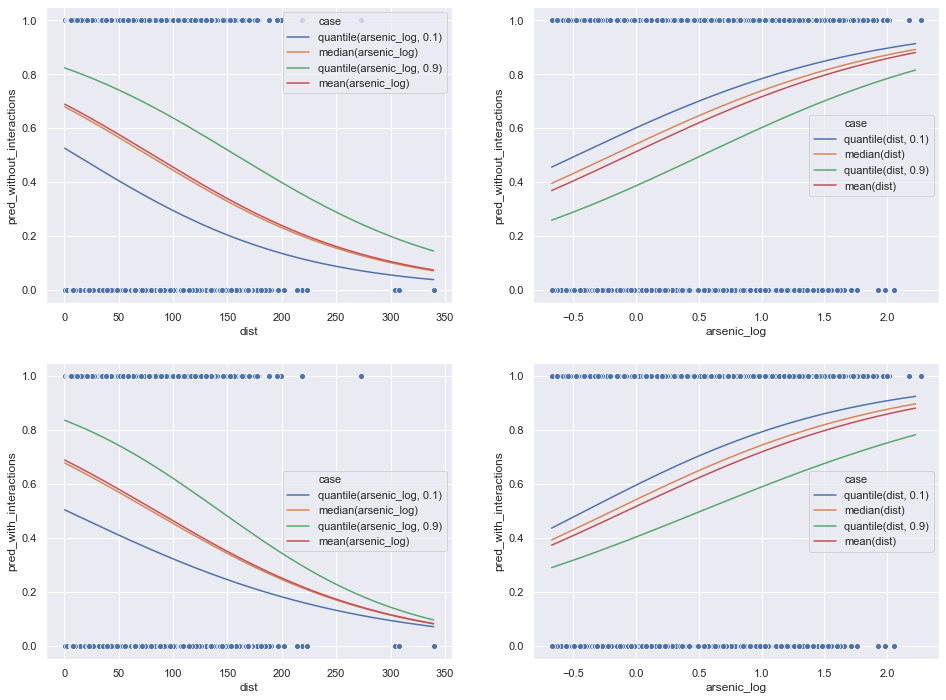

In [8]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2)
sns.scatterplot(data=switch_df, x="dist", y="switch", ax=ax11)
sns.lineplot(data=fit_for_constant_arsenic_log, x = "dist", y = "pred_without_interactions", hue="case", ax=ax11);

sns.scatterplot(data=switch_df, x="arsenic_log", y="switch", ax=ax12)
sns.lineplot(data=fit_for_constant_dist, x = "arsenic_log", y = "pred_without_interactions", hue="case", ax=ax12);

sns.scatterplot(data=switch_df, x="dist", y="switch", ax=ax21)
sns.lineplot(data=fit_for_constant_arsenic_log, x = "dist", y = "pred_with_interactions", hue="case", ax=ax21);

sns.scatterplot(data=switch_df, x="arsenic_log", y="switch", ax=ax22)
sns.lineplot(data=fit_for_constant_dist, x = "arsenic_log", y = "pred_with_interactions", hue="case", ax=ax22);
fig.set_size_inches(16, 12)

In [9]:
cases = pd.DataFrame([
    [0, np.log(1.6), 'a'],
    [100, np.log(1.6), 'a'],
    [100, np.log(1.6), 'b'],
    [200, np.log(1.6), 'b'],
    [100, np.log(0.5), 'c'],
    [100, np.log(1.0), 'c'],
    [100, np.log(1.0), 'd'],
    [100, np.log(2.0), 'd'],
], columns=['dist', 'arsenic_log', 'case']).assign(pred=lambda x: mdl_a_with_interactions.predict(x))

cases.join(cases.groupby('case').shift(-1).rename(columns=lambda x: x+"_cmp")).dropna().assign(
    pred_change=lambda x: x.pred_cmp - x.pred,

)

,dist,arsenic_log,case,pred,dist_cmp,arsenic_log_cmp,pred_cmp,pred_change
0,0,0.470004,a,0.721830,100.0,0.470004,0.492882,-0.228949
2,100,0.470004,b,0.492882,200.0,0.470004,0.266880,-0.226001
4,100,-0.693147,c,0.288281,100.0,0.000000,0.405608,0.117327
6,100,0.000000,d,0.405608,100.0,0.693147,0.534804,0.129196


* Houses which are 100 meters further from the well with the rest being equal are 22% less likely to switch.
* The probability of switching goes up 12% when doubling the amount of arsenic with the other factors being equal